In [38]:
from src.data_utils import Claim_Verification_Dataset, Variable_Mapping_Dataset
from allennlp.training.metrics import CategoricalAccuracy
import torch
from torch.utils.data import Dataset, DataLoader
from src.QA_models import T5_QA_From_Oracle_Facts, T5_QA_Only_Query
from src.QA_models import Standard_Transformer
from src.utils import CustomTrainer
from main import *
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
import wandb
import cloudpickle
import os
import string
from matplotlib import gridspec
from matplotlib.colors import LogNorm

%load_ext autoreload
%autoreload 2
%load_ext line_profiler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [4]:
variable_dataset = Variable_Mapping_Dataset(size=100000, triples_range=[2,3,4], hops_range=[0,1,2,3,4])

In [5]:
variable_dataset.data_map['train'][3]

{'facts': ["Q = 'j'",
  'W = U',
  'P = Z',
  "I = 'k'",
  'G = N',
  'S = B',
  'H = M',
  'L = W',
  'N = S',
  'N = Y',
  "C = 'x'",
  'H = X',
  'S = A',
  'F = P',
  'Q = H',
  'H = J',
  'Q = T',
  'C = L',
  "G = 'z'",
  'I = F',
  'X = E'],
 'question': 'What is the value of E?',
 'answer': 'j',
 'proof': 'E = X = H = Q = j'}

In [8]:
args = parser.parse_args("--name test --batch_sz 16 --epochs 5 --warmup_steps 200 --gpu_id 1".split(' '))
model = Standard_Transformer(args, t5_type='t5-small')

In [23]:
def validate_and_save_fn(trainer):
    dev_set = variable_dataset.data_map['dev'][:100]
    trainer.model.EM_accuracy.reset()
    trainer.model.inference(dev_set, chunk_size=64)
    print(dev_set[:2])
    valid_score = trainer.model.EM_accuracy.get_metric()
    
    if trainer.logger:
        trainer.logger.log_metrics({'variable_dataset_1_hop':valid_score})
        
    sorted_best_scores = sorted(trainer.model.validation_scores)
    print(f"Validated and got an exact match of: {valid_score:.3f}%")
    if valid_score > min(sorted_best_scores[-3:], default=-1):
        print(f"Best scores are {sorted_best_scores[-3:]}. Saving model.")
        trainer.model.validation_scores.append(valid_score)
        trainer.model.save(os.path.join('saved_models', model_name), f'model_valid_{valid_score:.2f}.sate_dict')

In [24]:
model_name = 'Standard_Transformer-base-variable-1-hop'
project_name = 'Reasoning_QA'
callback_fns = [validate_and_save_fn]
wandb_id = wandb.util.generate_id()

In [25]:
dataloader = DataLoader(variable_dataset.data_map['train'], batch_size=args.batch_sz, shuffle=True, collate_fn = model.collate)

In [26]:
my_trainer = CustomTrainer(gpus=args.gpu_id, gradient_clip_val=0.5, amp_level='O1', max_epochs=20, accumulate_grad_batches=4, steps_to_call=30, callback_fns=[validate_and_save_fn])
my_trainer.fit(model, dataloader)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name        | Type                | Params
----------------------------------------------------
0 | transformer | T5_Cond_Gen_Wrapper | 222 M 
1 | encoder     | T5Stack             | 109 M 
2 | decoder     | T5Stack             | 137 M 
3 | lm_head     | Linear              | 24.7 M
----------------------------------------------------
222 M     Trainable params
0         Non-trainable params
222 M     Total params
891.614   Total estimated model params size (MB)


Inference: 100%|██████████| 2/2 [00:07<00:00,  3.76s/it]


[{'facts': ['V = X', 'U = L', 'T = N', 'S = M', 'V = F', 'C = P', 'O = K', 'Y = A', 'W = U', 'R = H', 'Q = I', "T = 'z'", "C = 'g'", 'Z = D', 'R = B', 'B = S', 'J = Q', 'T = J', 'E = R', 'Y = O', 'I = Z', 'L = V', 'P = Y', "E = 'f'", "W = 'a'"], 'question': 'What is the value of Z?', 'answer': 'z', 'proof': 'Z = I = Q = J = T = z', 'all_generations': ['Answer: a Proof: Z = I = Q = J = R = P = C = a'], 'scores': tensor([1.]), 'top_output': 'Answer: a Proof: Z = I = Q = J = R = P = C = a', 'target_text': 'Answer: z Proof: Z = I = Q = J = T = z', 'EM': False}, {'facts': ['Q = F', 'Z = W', 'N = I', 'Z = S', 'P = N', 'C = O', 'C = A', 'Q = J', "Q = 'q'", "P = 'u'", "Z = 'a'", 'Z = U', "C = 'b'"], 'question': 'What is the value of N?', 'answer': 'u', 'proof': 'N = P = u', 'all_generations': ['Answer: u Proof: N = P = u'], 'scores': tensor([1.]), 'top_output': 'Answer: u Proof: N = P = u', 'target_text': 'Answer: u Proof: N = P = u', 'EM': True}]
Validated and got an exact match of: 0.570%
Be

Inference: 100%|██████████| 2/2 [00:05<00:00,  2.87s/it]


[{'facts': ['V = X', 'U = L', 'T = N', 'S = M', 'V = F', 'C = P', 'O = K', 'Y = A', 'W = U', 'R = H', 'Q = I', "T = 'z'", "C = 'g'", 'Z = D', 'R = B', 'B = S', 'J = Q', 'T = J', 'E = R', 'Y = O', 'I = Z', 'L = V', 'P = Y', "E = 'f'", "W = 'a'"], 'question': 'What is the value of Z?', 'answer': 'z', 'proof': 'Z = I = Q = J = T = z', 'all_generations': ['Answer: g Proof: Z = I = Q = J = T = g'], 'scores': tensor([1.]), 'top_output': 'Answer: g Proof: Z = I = Q = J = T = g', 'target_text': 'Answer: z Proof: Z = I = Q = J = T = z', 'EM': False}, {'facts': ['Q = F', 'Z = W', 'N = I', 'Z = S', 'P = N', 'C = O', 'C = A', 'Q = J', "Q = 'q'", "P = 'u'", "Z = 'a'", 'Z = U', "C = 'b'"], 'question': 'What is the value of N?', 'answer': 'u', 'proof': 'N = P = u', 'all_generations': ['Answer: u Proof: N = P = u'], 'scores': tensor([1.]), 'top_output': 'Answer: u Proof: N = P = u', 'target_text': 'Answer: u Proof: N = P = u', 'EM': True}]
Validated and got an exact match of: 0.650%
Best scores are [0

Inference: 100%|██████████| 2/2 [00:04<00:00,  2.42s/it]


[{'facts': ['V = X', 'U = L', 'T = N', 'S = M', 'V = F', 'C = P', 'O = K', 'Y = A', 'W = U', 'R = H', 'Q = I', "T = 'z'", "C = 'g'", 'Z = D', 'R = B', 'B = S', 'J = Q', 'T = J', 'E = R', 'Y = O', 'I = Z', 'L = V', 'P = Y', "E = 'f'", "W = 'a'"], 'question': 'What is the value of Z?', 'answer': 'z', 'proof': 'Z = I = Q = J = T = z', 'all_generations': ['Answer: z Proof: Z = I = Q = J = T = z'], 'scores': tensor([1.]), 'top_output': 'Answer: z Proof: Z = I = Q = J = T = z', 'target_text': 'Answer: z Proof: Z = I = Q = J = T = z', 'EM': True}, {'facts': ['Q = F', 'Z = W', 'N = I', 'Z = S', 'P = N', 'C = O', 'C = A', 'Q = J', "Q = 'q'", "P = 'u'", "Z = 'a'", 'Z = U', "C = 'b'"], 'question': 'What is the value of N?', 'answer': 'u', 'proof': 'N = P = u', 'all_generations': ['Answer: u Proof: N = P = u'], 'scores': tensor([1.]), 'top_output': 'Answer: u Proof: N = P = u', 'target_text': 'Answer: u Proof: N = P = u', 'EM': True}]
Validated and got an exact match of: 0.630%
Best scores are [0.

Inference: 100%|██████████| 2/2 [00:04<00:00,  2.39s/it]


[{'facts': ['V = X', 'U = L', 'T = N', 'S = M', 'V = F', 'C = P', 'O = K', 'Y = A', 'W = U', 'R = H', 'Q = I', "T = 'z'", "C = 'g'", 'Z = D', 'R = B', 'B = S', 'J = Q', 'T = J', 'E = R', 'Y = O', 'I = Z', 'L = V', 'P = Y', "E = 'f'", "W = 'a'"], 'question': 'What is the value of Z?', 'answer': 'z', 'proof': 'Z = I = Q = J = T = z', 'all_generations': ['Answer: f Proof: Z = I = Q = J = T = f'], 'scores': tensor([1.]), 'top_output': 'Answer: f Proof: Z = I = Q = J = T = f', 'target_text': 'Answer: z Proof: Z = I = Q = J = T = z', 'EM': False}, {'facts': ['Q = F', 'Z = W', 'N = I', 'Z = S', 'P = N', 'C = O', 'C = A', 'Q = J', "Q = 'q'", "P = 'u'", "Z = 'a'", 'Z = U', "C = 'b'"], 'question': 'What is the value of N?', 'answer': 'u', 'proof': 'N = P = u', 'all_generations': ['Answer: u Proof: N = P = u'], 'scores': tensor([1.]), 'top_output': 'Answer: u Proof: N = P = u', 'target_text': 'Answer: u Proof: N = P = u', 'EM': True}]
Validated and got an exact match of: 0.600%
Best scores are [0

Inference: 100%|██████████| 2/2 [00:04<00:00,  2.36s/it]


[{'facts': ['V = X', 'U = L', 'T = N', 'S = M', 'V = F', 'C = P', 'O = K', 'Y = A', 'W = U', 'R = H', 'Q = I', "T = 'z'", "C = 'g'", 'Z = D', 'R = B', 'B = S', 'J = Q', 'T = J', 'E = R', 'Y = O', 'I = Z', 'L = V', 'P = Y', "E = 'f'", "W = 'a'"], 'question': 'What is the value of Z?', 'answer': 'z', 'proof': 'Z = I = Q = J = T = z', 'all_generations': ['Answer: a Proof: Z = I = Q = J = T = a'], 'scores': tensor([1.]), 'top_output': 'Answer: a Proof: Z = I = Q = J = T = a', 'target_text': 'Answer: z Proof: Z = I = Q = J = T = z', 'EM': False}, {'facts': ['Q = F', 'Z = W', 'N = I', 'Z = S', 'P = N', 'C = O', 'C = A', 'Q = J', "Q = 'q'", "P = 'u'", "Z = 'a'", 'Z = U', "C = 'b'"], 'question': 'What is the value of N?', 'answer': 'u', 'proof': 'N = P = u', 'all_generations': ['Answer: u Proof: N = P = u'], 'scores': tensor([1.]), 'top_output': 'Answer: u Proof: N = P = u', 'target_text': 'Answer: u Proof: N = P = u', 'EM': True}]
Validated and got an exact match of: 0.710%
Best scores are [0

Inference: 100%|██████████| 2/2 [00:04<00:00,  2.48s/it]


[{'facts': ['V = X', 'U = L', 'T = N', 'S = M', 'V = F', 'C = P', 'O = K', 'Y = A', 'W = U', 'R = H', 'Q = I', "T = 'z'", "C = 'g'", 'Z = D', 'R = B', 'B = S', 'J = Q', 'T = J', 'E = R', 'Y = O', 'I = Z', 'L = V', 'P = Y', "E = 'f'", "W = 'a'"], 'question': 'What is the value of Z?', 'answer': 'z', 'proof': 'Z = I = Q = J = T = z', 'all_generations': ['Answer: z Proof: Z = I = Q = J = T = z'], 'scores': tensor([1.]), 'top_output': 'Answer: z Proof: Z = I = Q = J = T = z', 'target_text': 'Answer: z Proof: Z = I = Q = J = T = z', 'EM': True}, {'facts': ['Q = F', 'Z = W', 'N = I', 'Z = S', 'P = N', 'C = O', 'C = A', 'Q = J', "Q = 'q'", "P = 'u'", "Z = 'a'", 'Z = U', "C = 'b'"], 'question': 'What is the value of N?', 'answer': 'u', 'proof': 'N = P = u', 'all_generations': ['Answer: u Proof: N = P = u'], 'scores': tensor([1.]), 'top_output': 'Answer: u Proof: N = P = u', 'target_text': 'Answer: u Proof: N = P = u', 'EM': True}]
Validated and got an exact match of: 0.900%
Best scores are [0.

Inference: 100%|██████████| 2/2 [00:04<00:00,  2.39s/it]


[{'facts': ['V = X', 'U = L', 'T = N', 'S = M', 'V = F', 'C = P', 'O = K', 'Y = A', 'W = U', 'R = H', 'Q = I', "T = 'z'", "C = 'g'", 'Z = D', 'R = B', 'B = S', 'J = Q', 'T = J', 'E = R', 'Y = O', 'I = Z', 'L = V', 'P = Y', "E = 'f'", "W = 'a'"], 'question': 'What is the value of Z?', 'answer': 'z', 'proof': 'Z = I = Q = J = T = z', 'all_generations': ['Answer: z Proof: Z = I = Q = J = T = z'], 'scores': tensor([1.]), 'top_output': 'Answer: z Proof: Z = I = Q = J = T = z', 'target_text': 'Answer: z Proof: Z = I = Q = J = T = z', 'EM': True}, {'facts': ['Q = F', 'Z = W', 'N = I', 'Z = S', 'P = N', 'C = O', 'C = A', 'Q = J', "Q = 'q'", "P = 'u'", "Z = 'a'", 'Z = U', "C = 'b'"], 'question': 'What is the value of N?', 'answer': 'u', 'proof': 'N = P = u', 'all_generations': ['Answer: u Proof: N = P = u'], 'scores': tensor([1.]), 'top_output': 'Answer: u Proof: N = P = u', 'target_text': 'Answer: u Proof: N = P = u', 'EM': True}]
Validated and got an exact match of: 0.870%
Best scores are [0.

Inference: 100%|██████████| 2/2 [00:04<00:00,  2.43s/it]


[{'facts': ['V = X', 'U = L', 'T = N', 'S = M', 'V = F', 'C = P', 'O = K', 'Y = A', 'W = U', 'R = H', 'Q = I', "T = 'z'", "C = 'g'", 'Z = D', 'R = B', 'B = S', 'J = Q', 'T = J', 'E = R', 'Y = O', 'I = Z', 'L = V', 'P = Y', "E = 'f'", "W = 'a'"], 'question': 'What is the value of Z?', 'answer': 'z', 'proof': 'Z = I = Q = J = T = z', 'all_generations': ['Answer: z Proof: Z = I = Q = J = T = z'], 'scores': tensor([1.]), 'top_output': 'Answer: z Proof: Z = I = Q = J = T = z', 'target_text': 'Answer: z Proof: Z = I = Q = J = T = z', 'EM': True}, {'facts': ['Q = F', 'Z = W', 'N = I', 'Z = S', 'P = N', 'C = O', 'C = A', 'Q = J', "Q = 'q'", "P = 'u'", "Z = 'a'", 'Z = U', "C = 'b'"], 'question': 'What is the value of N?', 'answer': 'u', 'proof': 'N = P = u', 'all_generations': ['Answer: u Proof: N = P = u'], 'scores': tensor([1.]), 'top_output': 'Answer: u Proof: N = P = u', 'target_text': 'Answer: u Proof: N = P = u', 'EM': True}]
Validated and got an exact match of: 0.900%
Best scores are [0.

1

In [9]:
model.load('saved_models/Standard_Transformer-small-variable-1-hop/model_valid_0.98.sate_dict')

In [10]:
hard_dataset = Variable_Mapping_Dataset(size=100, triples_range=[5], hops_range=[5], distractors_range=[1])
custom_samples = hard_dataset.data_map['all']
custom_samples[0]

{'facts': ['H = E',
  'F = X',
  "Z = 'r'",
  'A = P',
  'W = O',
  'M = T',
  'I = J',
  'T = N',
  'Q = W',
  'D = F',
  'L = C',
  'O = U',
  "K = 'n'",
  "G = 'p'",
  'X = I',
  "B = 'j'",
  'Z = A',
  'P = R',
  'G = L',
  'Y = M',
  'B = Q',
  'K = Y',
  'R = H',
  'S = V',
  'C = S',
  "D = 'a'"],
 'question': 'What is the value of E?',
 'answer': 'r',
 'proof': 'E = H = R = P = A = Z = r'}

In [12]:
model.to('cuda:1')
model.metric_reset()
model.inference(custom_samples)
model.EM_accuracy.get_metric()

Inference: 100%|██████████| 2/2 [00:05<00:00,  2.59s/it]


0.0

In [69]:
model.visualise(custom_samples[0])

interactive(children=(SelectionSlider(continuous_update=False, description='Selected token:', options=('7781->…

In [68]:
%debug

> /nfs/Complex_Decomposition_QA/src/QA_models.py(473)visualise_for_token()
    471 
    472     def visualise_for_token(self, sample, target_id):
--> 473         target_id = int(target_id.split('->')[1]) if isinstance(target_id, str) else target_id
    474         sample = self.inference([sample], return_hidden_states=True)[0]
    475 



ipdb>  target_id


'7781->Cla'


ipdb>  exit


In [17]:
custom_samples = [{'facts': ["K = 'f'",
  'P = T',
  'H = Z',
  'W = U'],
 'question': 'What is the value of K?'},
                 {'facts': ["K = 'f'",
  'P = T',
  'H = Z',
  'K = F'],
 'question': 'What is the value of K'}]
model.inference(custom_samples, return_hidden_states=True)
custom_samples[0]['decoder_hidden_states'].shape

Inference: 100%|██████████| 1/1 [00:00<00:00,  6.85it/s]


torch.Size([11, 7, 512])

In [26]:
encoder_dots = model.transformer.lm_head(custom_samples[0]['encoder_hidden_states']).argsort(descending=True).tolist()
decoder_dots = model.transformer.lm_head(custom_samples[0]['decoder_hidden_states']).argsort(descending=True).tolist()

In [21]:
custom_samples[0]['encoder_input_ids'].flatten()

tensor([ 7781,   603,    10,   363,    19,     8,   701,    13,   480,    58,
         1820,  9175,  9175, 11543,     7,    10,   480,  3274,     3,    31,
           89,    31,  1820,   276,  3274,   332,  1820,   454,  3274,  1027,
         1820,   549,  3274,   412,     1], device='cuda:1')

In [54]:
target_id = 480

In [55]:
encoder_ids = custom_samples[0]['encoder_input_ids'].flatten()
decoder_ids = custom_samples[0]['decoder_input_ids']

encoder_tokens = model.tokenizer.batch_decode(encoder_ids.view(-1,1))
decoder_tokens = model.tokenizer.batch_decode(decoder_ids.view(-1,1))

layers = custom_samples[0]['encoder_hidden_states'].shape[1]
encoder_plot = torch.zeros((layers, len(encoder_ids)), dtype=torch.int)
decoder_plot = torch.zeros((layers, len(decoder_ids)-1), dtype=torch.int)

# encoder 
for row in tqdm(range(layers)):
    for column in range(len(encoder_ids)):
        rank = encoder_dots[column][row].index(target_id)     #(input_ids[column+1])
        encoder_plot[row, column] = rank
        
# decoder
for row in tqdm(range(layers)):
    for column in range(len(decoder_ids)-1):
        rank = decoder_dots[column][row].index(target_id)     #(input_ids[column+1])
        decoder_plot[row, column] = rank

100%|██████████| 7/7 [00:00<00:00, 1971.93it/s]


In [53]:
for idx in encoder_ids:
    print(f"'{model.tokenizer.decode([idx])}' -> {idx}")
print('------------------')
for idx in decoder_ids:
    print(f"'{model.tokenizer.decode([idx])}' -> {idx}")

'Cla' -> 7781
'im' -> 603
':' -> 10
'What' -> 363
'is' -> 19
'the' -> 8
'value' -> 701
'of' -> 13
'K' -> 480
'?' -> 58
'|' -> 1820
'|' -> 9175
'|' -> 9175
'Fact' -> 11543
's' -> 7
':' -> 10
'K' -> 480
'=' -> 3274
'' -> 3
''' -> 31
'f' -> 89
''' -> 31
'|' -> 1820
'P' -> 276
'=' -> 3274
'T' -> 332
'|' -> 1820
'H' -> 454
'=' -> 3274
'Z' -> 1027
'|' -> 1820
'W' -> 549
'=' -> 3274
'U' -> 412
'</s>' -> 1
------------------
'<pad>' -> 0
'Answer' -> 11801
':' -> 10
'' -> 3
'f' -> 89
'Proof' -> 25029
':' -> 10
'K' -> 480
'=' -> 3274
'' -> 3
'f' -> 89
'</s>' -> 1


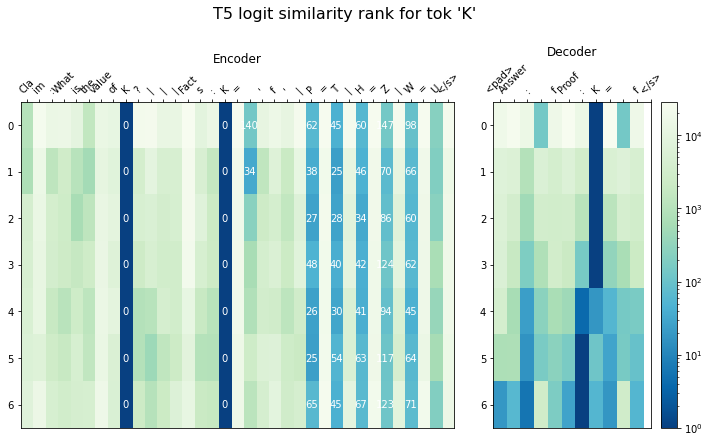

In [58]:
# fig, [ax1, ax2] = plt.subplots(1, 2, constrained_layout=True)
fig = plt.figure(figsize=(12, 6))
ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 3), (0, 2), colspan=1)

gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 
h1 = ax1.imshow(encoder_plot+1, norm=LogNorm(), cmap=plt.cm.GnBu_r, aspect='auto')
h2 = ax2.imshow(decoder_plot+1, norm=LogNorm(), cmap=plt.cm.GnBu_r, aspect='auto')

ax1.xaxis.set_ticks(range(len(encoder_tokens)))
ax1.set_xticklabels(encoder_tokens, minor=False, rotation = 45)

# Loop over data dimensions and create text annotations.
for i in range(layers):
    for j in range(len(encoder_tokens)):
        if encoder_plot[i, j] < 200:
            text = ax1.text(j, i, int(encoder_plot[i, j]),
                           ha="center", va="center", color="w")

ax2.xaxis.set_ticks(range(len(decoder_tokens)))
ax2.set_xticklabels(decoder_tokens, minor=False, rotation = 45)
ax1.xaxis.tick_top()
ax2.xaxis.tick_top()

ax1.set_title("Encoder")
ax2.set_title("Decoder")
fig.suptitle(f"T5 logit similarity rank for tok '{model.tokenizer.decode([target_id])}'", fontsize=16, y=1.1)

fig.colorbar(h2, ax=ax2)
plt.show(block=False) 

In [16]:
custom_samples[0]

{'facts': ["K = 'f'", 'P = T', 'H = Z', 'W = U'],
 'question': 'What is the value of K?',
 'encoder_input_ids': tensor([[ 7781,   603,    10,   363,    19,     8,   701,    13,   480,    58,
           1820,  9175,  9175, 11543,     7,    10,   480,  3274,     3,    31,
             89,    31,  1820,   276,  3274,   332,  1820,   454,  3274,  1027,
           1820,   549,  3274,   412,     1]], device='cuda:1'),
 'decoder_input_ids': tensor([    0, 11801,    10,     3,    89, 25029,    10,   480,  3274,     3,
            89,     1], device='cuda:1'),
 'all_generations': ['Answer: f Proof: K = f'],
 'scores': tensor([1.]),
 'top_output': 'Answer: f Proof: K = f',
 'encoder_hidden_states': tensor([[[-9.4388e+00,  6.3108e-01, -1.6500e+01,  ..., -1.6502e+01,
            4.8499e+01,  7.1895e+00],
          [ 2.4707e+00,  1.0071e+01, -1.5979e+01,  ..., -1.8241e+01,
            1.9600e+01,  4.0102e+00],
          [ 2.9066e+01,  1.7077e+01, -3.6287e+01,  ..., -3.8816e+01,
            3.2395e+